# 0.import libraries

In [ ]:
from IPython.display import clear_output 

In [ ]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
!pip install tensorflow==2.9.1
clear_output()

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.1


In [ ]:
!pip install shap
clear_output()

In [ ]:
import shap

# 1.import data

In [ ]:
# read data and drop the first column
raw_test_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1jrv549VVFST4VcX1kFkXR8AdrT7MEOTI', 
                  sep=",", engine = "python").iloc[:, 1:]
raw_train_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1gU6xMwaSiF2h28kHrmtHUXgeK3zbonYW',  
                  sep=",", engine = "python").iloc[:, 1:]

In [ ]:
# concatnate data
raw_dataset = pd.concat([raw_train_data,raw_test_data], ignore_index=True) 

print("Final data:", raw_dataset.shape)

Final data: (2086, 11)


In [ ]:
dataset = raw_dataset.copy()
dataset.tail()

,y,52TI766,52PI250,52FC231,52TI737,52FC1127,52TI878,52TI735,52FR235,52FC133,52FC1143
2081,421.000000,380.747197,21.005340,9.716553,126.865234,5.211556,97.313604,371.968021,410.723214,7244.375000,748.875
2082,418.648438,383.370159,20.994468,10.038086,132.445312,6.913452,127.921623,374.136621,394.287279,6506.625000,748.875
2083,426.125000,389.131153,21.087402,9.616152,129.277344,7.552368,108.046875,379.851520,405.304688,6989.034556,748.875
2084,425.093750,388.976562,21.125000,9.617188,127.630837,7.511318,119.244141,380.234375,395.364424,7188.000000,748.875
2085,425.890625,389.984375,20.969727,9.545410,128.945312,7.493811,114.288483,380.523438,382.575166,7058.625000,748.875


In [ ]:
# Check if the data containes na values
dataset.isna().sum()

y           0
52TI766     0
52PI250     0
52FC231     0
52TI737     0
52FC1127    0
52TI878     0
52TI735     0
52FR235     0
52FC133     0
52FC1143    0
dtype: int64

In [ ]:
# Split the data into training and test sets
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# 2.explore data

In [ ]:
features = train_dataset.columns
features

Index(['y', '52TI766', '52PI250', '52FC231', '52TI737', '52FC1127', '52TI878',
       '52TI735', '52FR235', '52FC133', '52FC1143'],
      dtype='object')

In [ ]:
raw_dataset.columns=['y','Feature 1','Feature 2','Feature 3','Feature 4','Feature 5','Feature 6','Feature 7','Feature 8','Feature 9','Feature 10']

In [ ]:
from scipy import stats
raw_dataset=raw_dataset.dropna()[(np.abs(stats.zscore(raw_dataset.dropna())) < 5).all(axis=1)]

In [ ]:
raw_dataset.shape

(2076, 11)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d18556410>,
      dtype=object)

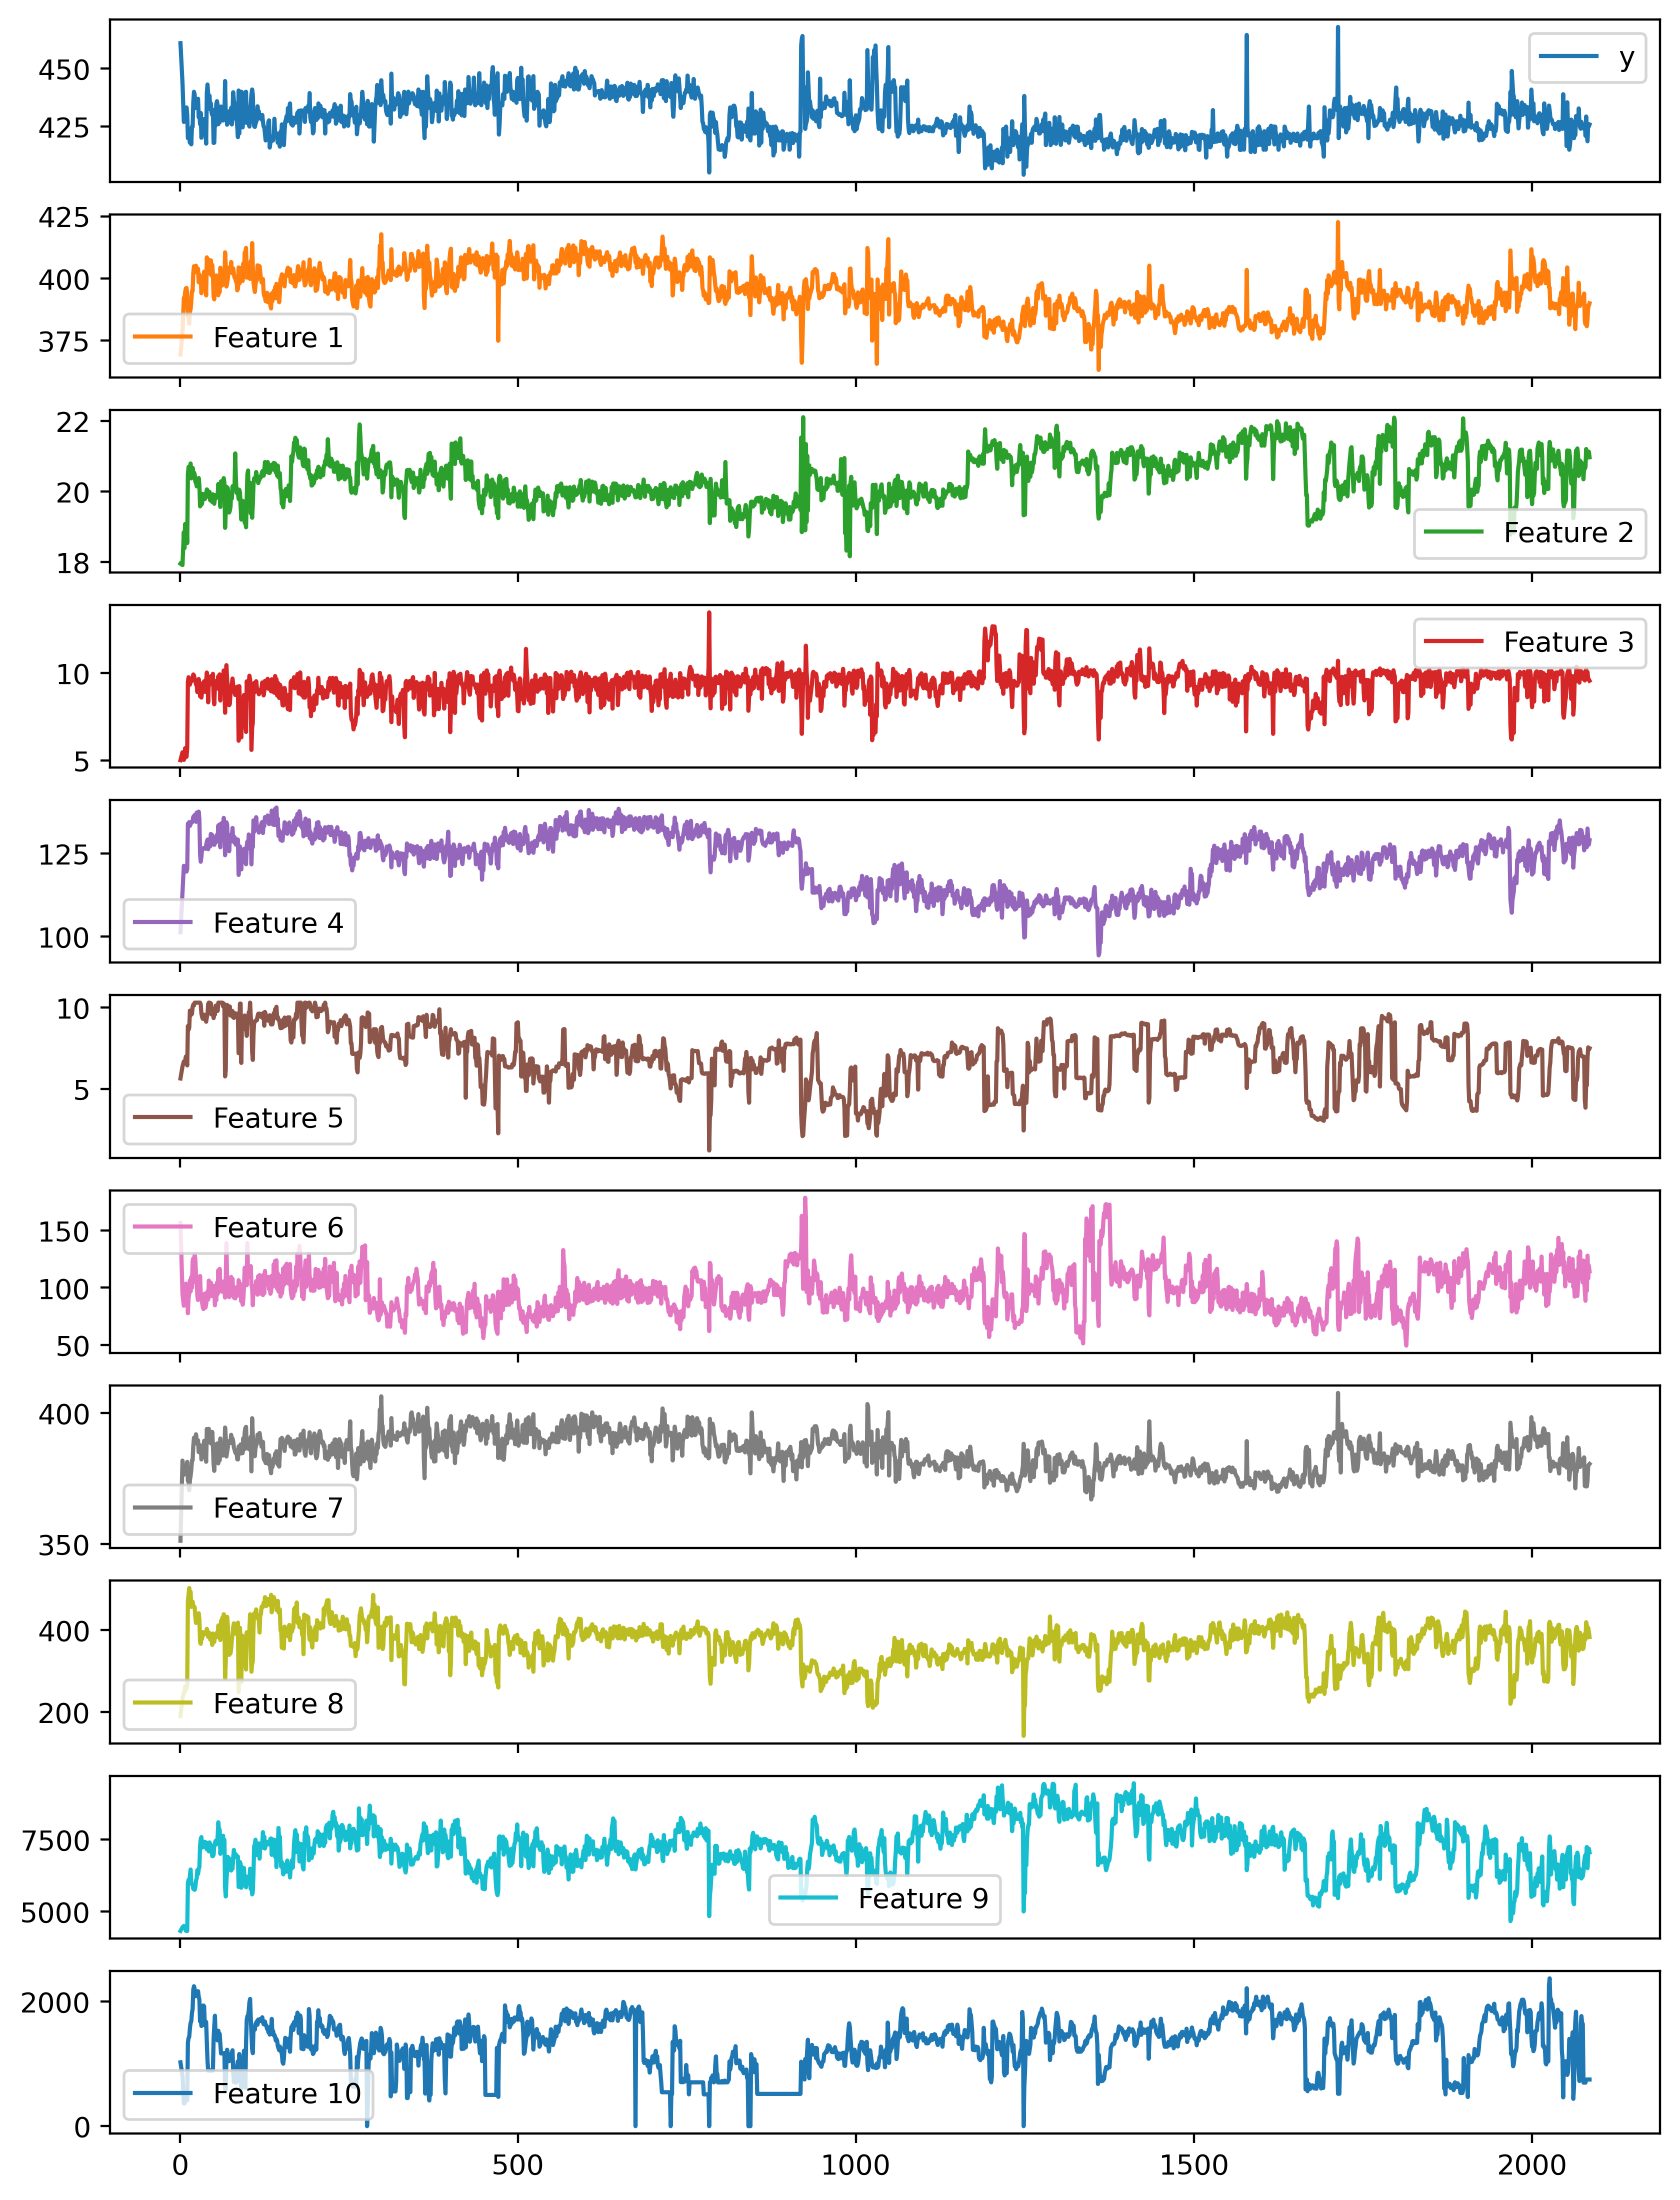

In [ ]:
plt.rcParams['figure.dpi']=400
raw_dataset .plot(subplots=True,figsize=(10, 14))

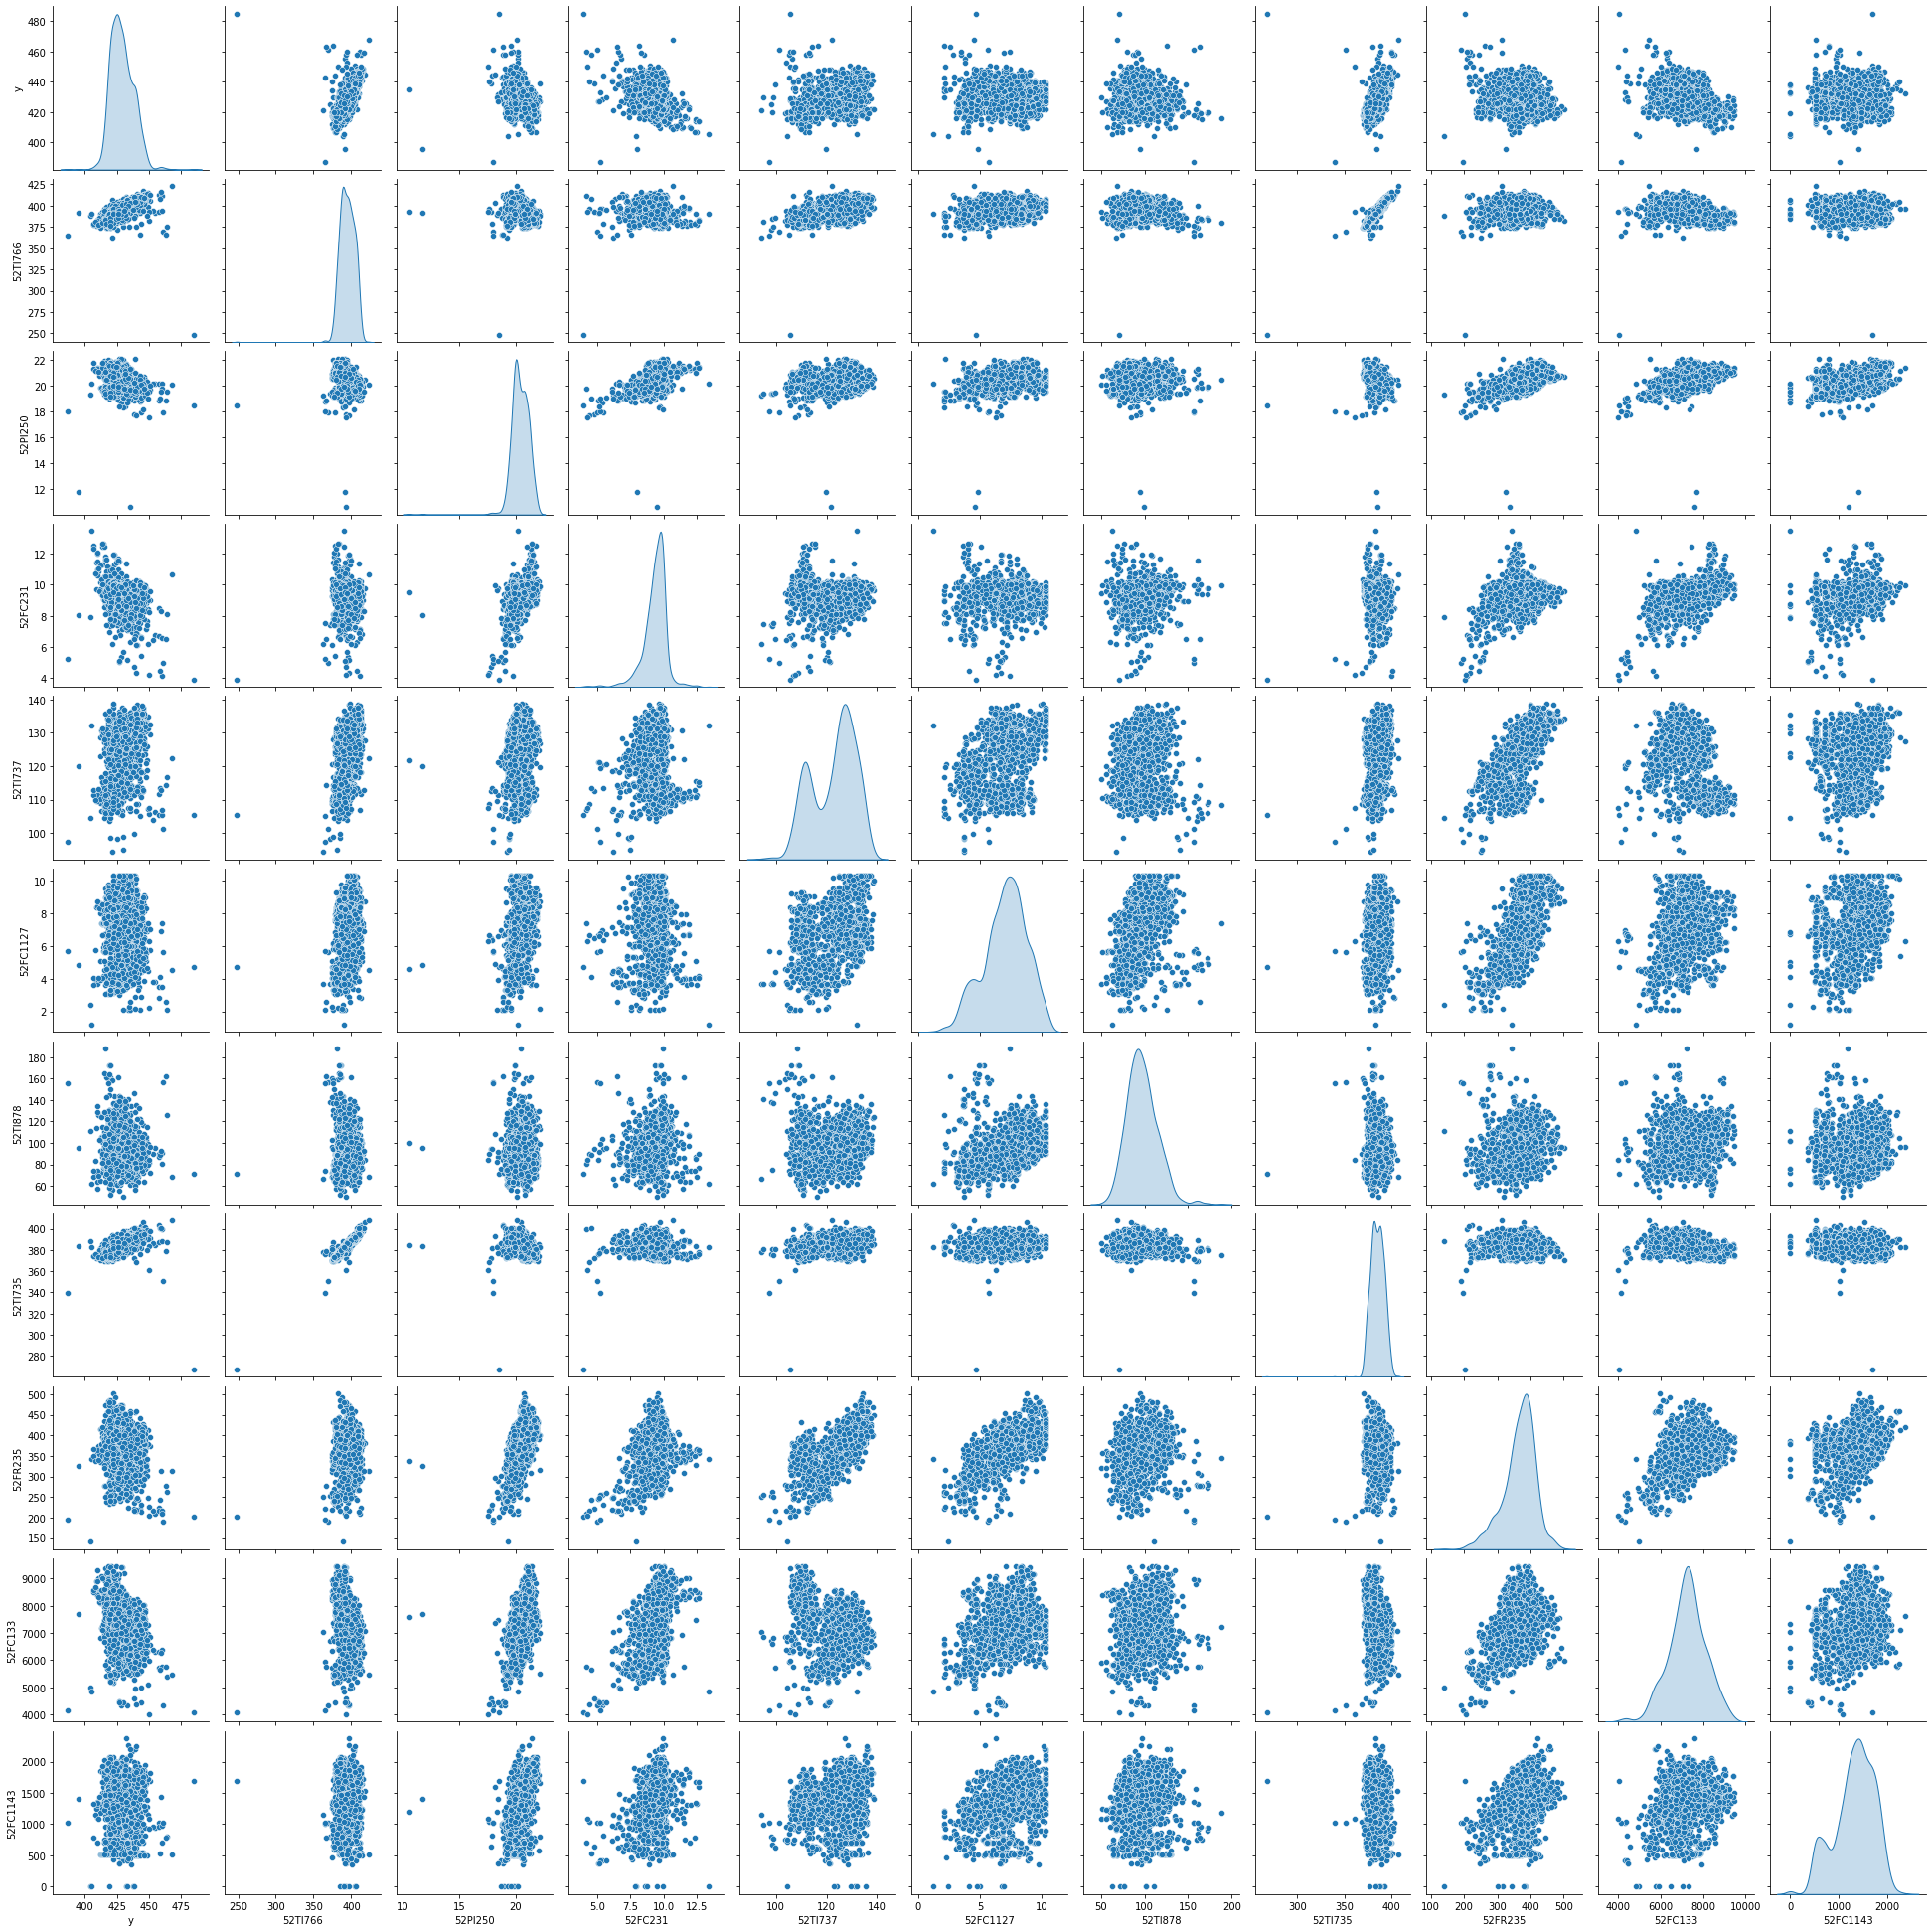

In [ ]:
sns.pairplot(train_dataset[['y', '52TI766', '52PI250', '52FC231', '52TI737', '52FC1127', '52TI878',
       '52TI735', '52FR235', '52FC133', '52FC1143']], diag_kind='kde')

In [ ]:
# check the overall statistics
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
y,1669.0,428.847537,8.875504,386.867188,422.085938,427.835938,435.000000,485.000000
52TI766,1669.0,394.357915,9.849038,248.540184,387.519492,394.301674,401.652936,422.750000
52PI250,1669.0,20.390591,0.751382,10.604565,19.909048,20.357910,20.914455,22.103763
52FC231,1669.0,9.342524,0.898359,3.917847,8.980504,9.486084,9.877634,13.448091
52TI737,1669.0,122.700655,8.618678,94.373165,114.376953,125.013672,129.421763,138.761161
52FC1127,1669.0,7.017961,1.728312,1.201515,5.969535,7.193438,8.240918,10.306641
52TI878,1669.0,96.901193,17.656341,49.589844,84.738281,95.257591,107.173710,188.265882
52TI735,1669.0,384.736313,7.507523,267.406250,379.757812,384.743292,389.962031,407.616800
52FR235,1669.0,365.809255,48.474722,141.066406,341.905315,373.780080,398.524475,502.312500
52FC133,1669.0,7253.108958,871.381661,4009.217486,6733.649194,7276.227273,7800.847749,9469.423321


# 3.process data

In [ ]:
# split features from labels 
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('y')
test_labels = test_features.pop('y')

> normalization:

In [ ]:
# see how different the ranges of each feature are:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
y,428.847537,8.875504
52TI766,394.357915,9.849038
52PI250,20.390591,0.751382
52FC231,9.342524,0.898359
52TI737,122.700655,8.618678
52FC1127,7.017961,1.728312
52TI878,96.901193,17.656341
52TI735,384.736313,7.507523
52FR235,365.809255,48.474722
52FC133,7253.108958,871.381661


In [ ]:
# create the layer:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [ ]:
# fit the state of the preprocessing layer to the data by calling Normalization.adapt:
normalizer.adapt(np.array(train_features))

In [ ]:
# calculate the mean and variance, and store them in the layer:
print(normalizer.mean.numpy())

[[ 394.358   20.391    9.343  122.701    7.018   96.901  384.736  365.809
  7253.109 1322.847]]


In [ ]:
# When the layer is called, it returns the input data, with each feature independently normalized:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 406.57   20.51    9.34  127.08    8.81   87.22  395.61  408.28 7586.57
  1450.16]]

Normalized: [[ 1.24  0.16  0.    0.51  1.04 -0.55  1.45  0.88  0.38  0.31]]


# 4.regression using a DNN

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, 
                                       beta_1=0.9, beta_2=0.999, 
                                       epsilon=1e-07, amsgrad=False),
    loss='mean_absolute_percentage_error')
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 10)               21        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,950
Trainable params: 4,929
Non-trainable params: 21
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 11.4 s, sys: 739 ms, total: 12.2 s
Wall time: 10.4 s


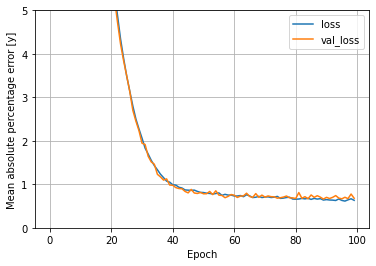

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 5])
# plt.xlim()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute percentage error [y]')
plt.legend()
plt.grid(True)

In [ ]:
# Collect the results on the test set for later:
test_results = {}

In [ ]:
# Collect the results on the test set:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
dnn_model.evaluate(test_features, test_labels, verbose=0)

0.7526328563690186

# 5.performance

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute percentage error [y]']).T

,Mean absolute percentage error [y]
dnn_model,0.752633


# 6.make predictions

14/14 [==============================] - 0s 2ms/step


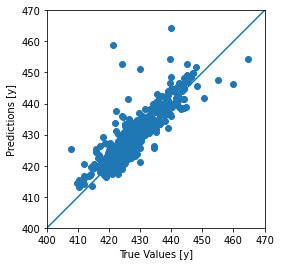

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [y]')
plt.ylabel('Predictions [y]')
lims = [400, 470]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

> It appears that the model predicts reasonably well. Now, check the error distribution:

In [ ]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(test_labels, test_predictions)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_absolute_percentage_error_1 = mean_squared_error(test_labels, test_predictions, squared=False)

In [ ]:
print("R_Sqaure",coefficient_of_dermination)
print("mean_absolute_percentage_error", mean_absolute_percentage_error_1)

R_Sqaure 0.684455230125179
mean_absolute_percentage_error 4.860860413570131


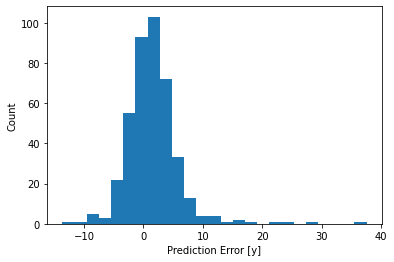

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [y]')
_ = plt.ylabel('Count')

# 7.shap

In [ ]:
x = dataset.iloc[:, dataset.columns != 'y']
y = dataset['y']

In [ ]:
explainer = shap.Explainer(dnn_model.predict, x)

In [ ]:
shap_values = explainer(x[:100])

3200/3200 [==============================] - 5s 2ms/step


Exact explainer:   1%|          | 1/100 [00:00<?, ?it/s]

35/35 [==============================] - 0s 1ms/step


Exact explainer:   3%|▎         | 3/100 [00:20<08:24,  5.20s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:   4%|▍         | 4/100 [00:28<09:57,  6.22s/it]

35/35 [==============================] - 0s 4ms/step


Exact explainer:   5%|▌         | 5/100 [00:38<12:26,  7.86s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:   6%|▌         | 6/100 [00:50<14:11,  9.06s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:   7%|▋         | 7/100 [01:00<14:44,  9.51s/it]

35/35 [==============================] - 0s 6ms/step


Exact explainer:   8%|▊         | 8/100 [01:11<15:16,  9.96s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:   9%|▉         | 9/100 [01:19<14:12,  9.37s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  10%|█         | 10/100 [01:30<14:33,  9.71s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  11%|█         | 11/100 [01:40<14:43,  9.93s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  12%|█▏        | 12/100 [01:50<14:48, 10.10s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  13%|█▎        | 13/100 [01:56<12:44,  8.79s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  14%|█▍        | 14/100 [02:02<11:17,  7.88s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  15%|█▌        | 15/100 [02:08<10:14,  7.23s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  16%|█▌        | 16/100 [02:18<11:29,  8.21s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  17%|█▋        | 17/100 [02:25<10:50,  7.83s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  18%|█▊        | 18/100 [02:33<10:34,  7.73s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  19%|█▉        | 19/100 [02:43<11:31,  8.53s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  20%|██        | 20/100 [02:54<12:09,  9.12s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  21%|██        | 21/100 [02:59<10:41,  8.12s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  22%|██▏       | 22/100 [03:05<09:40,  7.45s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  23%|██▎       | 23/100 [03:11<08:54,  6.95s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  24%|██▍       | 24/100 [03:21<10:06,  7.99s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  25%|██▌       | 25/100 [03:28<09:37,  7.70s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  26%|██▌       | 26/100 [03:34<08:49,  7.15s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  27%|██▋       | 27/100 [03:40<08:14,  6.78s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  28%|██▊       | 28/100 [03:51<09:26,  7.87s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  29%|██▉       | 29/100 [03:56<08:34,  7.24s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  30%|███       | 30/100 [04:02<07:59,  6.84s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  31%|███       | 31/100 [04:08<07:31,  6.54s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  32%|███▏      | 32/100 [04:14<07:12,  6.37s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  33%|███▎      | 33/100 [04:20<06:56,  6.22s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  34%|███▍      | 34/100 [04:26<06:42,  6.09s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▌      | 35/100 [04:33<06:53,  6.36s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  36%|███▌      | 36/100 [04:39<06:49,  6.40s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  37%|███▋      | 37/100 [04:45<06:33,  6.25s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  38%|███▊      | 38/100 [04:54<07:22,  7.14s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  39%|███▉      | 39/100 [05:05<08:15,  8.12s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  40%|████      | 40/100 [05:15<08:49,  8.83s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  41%|████      | 41/100 [05:21<07:48,  7.94s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  42%|████▏     | 42/100 [05:32<08:23,  8.68s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  43%|████▎     | 43/100 [05:37<07:25,  7.82s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  44%|████▍     | 44/100 [05:48<08:01,  8.60s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▌     | 45/100 [05:58<08:23,  9.16s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  46%|████▌     | 46/100 [06:09<08:36,  9.56s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  47%|████▋     | 47/100 [06:19<08:40,  9.81s/it]

35/35 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 48/100 [06:26<07:49,  9.02s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  49%|████▉     | 49/100 [06:37<08:03,  9.47s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  50%|█████     | 50/100 [06:43<06:59,  8.40s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  51%|█████     | 51/100 [06:53<07:21,  9.00s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  52%|█████▏    | 52/100 [06:59<06:27,  8.07s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  53%|█████▎    | 53/100 [07:05<05:44,  7.33s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  54%|█████▍    | 54/100 [07:15<06:19,  8.26s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  55%|█████▌    | 55/100 [07:26<06:40,  8.90s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  56%|█████▌    | 56/100 [07:32<05:58,  8.15s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  57%|█████▋    | 57/100 [07:42<06:20,  8.85s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  58%|█████▊    | 58/100 [07:48<05:30,  7.88s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  59%|█████▉    | 59/100 [07:59<05:55,  8.66s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  60%|██████    | 60/100 [08:04<05:12,  7.82s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  61%|██████    | 61/100 [08:10<04:42,  7.25s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  62%|██████▏   | 62/100 [08:16<04:20,  6.85s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 63/100 [08:22<04:03,  6.57s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  64%|██████▍   | 64/100 [08:28<03:49,  6.38s/it]

35/35 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 65/100 [08:39<04:26,  7.62s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  66%|██████▌   | 66/100 [08:49<04:47,  8.46s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  67%|██████▋   | 67/100 [08:59<04:58,  9.05s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  68%|██████▊   | 68/100 [09:05<04:18,  8.07s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  69%|██████▉   | 69/100 [09:16<04:32,  8.80s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  70%|███████   | 70/100 [09:26<04:38,  9.28s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  71%|███████   | 71/100 [09:32<04:00,  8.28s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  72%|███████▏  | 72/100 [09:38<03:32,  7.59s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 73/100 [09:44<03:11,  7.08s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  74%|███████▍  | 74/100 [09:54<03:30,  8.08s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  75%|███████▌  | 75/100 [10:00<03:05,  7.43s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  76%|███████▌  | 76/100 [10:06<02:47,  6.96s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  77%|███████▋  | 77/100 [10:12<02:32,  6.64s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  78%|███████▊  | 78/100 [10:18<02:21,  6.43s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  79%|███████▉  | 79/100 [10:24<02:11,  6.25s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  80%|████████  | 80/100 [10:30<02:03,  6.15s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  81%|████████  | 81/100 [10:36<01:55,  6.09s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  82%|████████▏ | 82/100 [10:43<01:55,  6.42s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  83%|████████▎ | 83/100 [10:49<01:48,  6.38s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  84%|████████▍ | 84/100 [11:00<02:01,  7.61s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  85%|████████▌ | 85/100 [11:05<01:46,  7.09s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  86%|████████▌ | 86/100 [11:16<01:53,  8.11s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  87%|████████▋ | 87/100 [11:22<01:36,  7.46s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  88%|████████▊ | 88/100 [11:27<01:22,  6.89s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  89%|████████▉ | 89/100 [11:38<01:27,  7.95s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  90%|█████████ | 90/100 [11:44<01:13,  7.32s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  91%|█████████ | 91/100 [11:50<01:01,  6.88s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  92%|█████████▏| 92/100 [12:00<01:03,  7.94s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  93%|█████████▎| 93/100 [12:10<01:00,  8.68s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  94%|█████████▍| 94/100 [12:16<00:47,  7.87s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  95%|█████████▌| 95/100 [12:27<00:43,  8.65s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  96%|█████████▌| 96/100 [12:37<00:36,  9.18s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  97%|█████████▋| 97/100 [12:48<00:28,  9.55s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer:  98%|█████████▊| 98/100 [12:58<00:19,  9.84s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  99%|█████████▉| 99/100 [13:09<00:10, 10.03s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer: 100%|██████████| 100/100 [13:15<00:00,  8.77s/it]

35/35 [==============================] - 0s 1ms/step


Exact explainer: 101it [13:20,  8.01s/it]


## heatmap

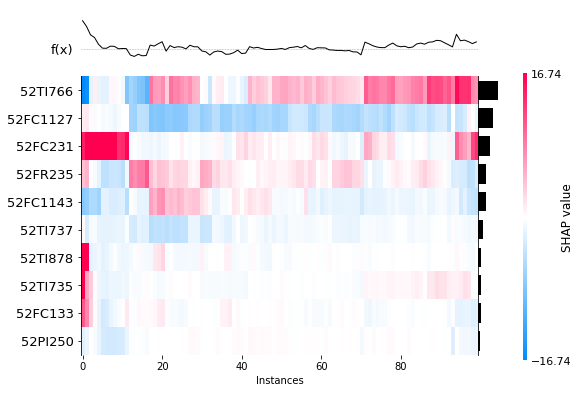

In [ ]:
shap_values_explaination = shap.Explanation(shap_values, feature_names=x.columns.tolist()) 
shap.plots.heatmap(shap_values_explaination)

## feature importance summary

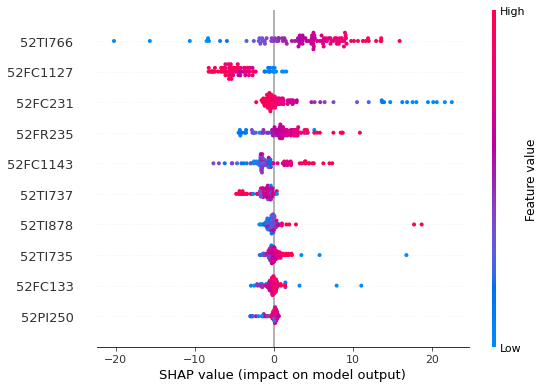

In [ ]:
# a granular look at feature importances for the entire data set.
shap.summary_plot(shap_values, x[:100])

## explain the entire dataset

In [ ]:
expected_value = shap_values.base_values[0]

In [ ]:
# # load JS visualization code to notebook
# shap.initjs()

# # plot
# shap.plots.force(expected_value, shap_values)